# Modelo de validación de estrés de voz

In [1]:
!pip install keras_vggface
!pip install keras_applications
!pip install -U tensorflow-addons
!pip install -q "tqdm>=4.36.1"
!pip install keras-utils

     |████████████████████████████████| 50 kB 4.0 MB/s 
     |████████████████████████████████| 679 kB 6.8 MB/s 
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2657 sha256=79a8f6440be0e2ae6c9254b565ce4cdf4e7e1743f809a2b9c06d6292b235e413
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras-utils


In [2]:
import os 
import math   
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd

import cv2     # Para capturar videos
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    
from keras.utils import np_utils
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from skimage.transform import resize   # for resizing images

import tensorflow as tf


import dlib # Extraer rostro
from google.colab.patches import cv2_imshow

import joblib

import keras.applications
#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD


In [3]:
from tensorflow.keras.utils import to_categorical

In [4]:
# Establecer conecxión con drive para extraer los datos
from google.colab import drive #Conexión con Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
#Ubicación de los datos 
PATH = '/content/drive/MyDrive/Hackaton zinobe/Dataset/DATOS_PREPROCESADOS_AUDIO/Model_audio_img1'

# lista de archivos de video
dir_list = os.listdir(PATH)


#Análisis de Audio

### Carga de Datos 

In [6]:
X = joblib.load(PATH+'/X1.joblib')
y = joblib.load(PATH+'/Y1.joblib'); y=np.array(y)
y=to_categorical(y)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.02)

In [8]:
print('Dimensión datos entrenamiento(X):',X_train.shape)
print('Dimensión datos entrenamiento(y):',y_train.shape)

Dimensión datos entrenamiento(X): (376, 223, 217, 3)
Dimensión datos entrenamiento(y): (376, 2)


In [9]:
print('Dimensión datos de prueba(X):',X_test.shape)
print('Dimensión datos de prueba(y):',y_test.shape)

Dimensión datos de prueba(X): (8, 223, 217, 3)
Dimensión datos de prueba(y): (8, 2)


In [10]:
IMG_SIZE1 = X_train.shape[1] 
IMG_SIZE2 = X_train.shape[2] 
N_CLASSES = 2

### Modelo 

In [11]:
from keras.applications.inception_v3 import InceptionV3
import tensorflow_addons as tfa

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

In [24]:
def inception_audio(use_imagenet=True):
    #model = InceptionV3(include_top=False, input_shape=(IMG_SIZE1, IMG_SIZE2, 3),
    #                                     weights='imagenet' if use_imagenet else None)
    #model = VGG19(include_top=False, input_shape=(IMG_SIZE1, IMG_SIZE2, 3),
    #                                      weights='imagenet' if use_imagenet else None)
    model = MobileNet(include_top=False,input_shape=(IMG_SIZE1, IMG_SIZE2, 3),
                                 weights='imagenet')
    #model=Sequential()
    new_output=Conv2D(filters=16,kernel_size=[3,3],padding='same')(model.output)
    new_output=LeakyReLU(0.1)(new_output)
    new_output=Conv2D(filters=32,kernel_size=[3,3],padding='same')(new_output)
    new_output=LeakyReLU(0.1)(new_output)
    new_output=BatchNormalization()(new_output)
    new_output=MaxPooling2D(padding='same')(new_output)
    new_output=Dropout(0.25)(new_output)
    new_output=Conv2D(filters=32,kernel_size=[3,3],padding='same')(new_output)
    new_output=LeakyReLU(0.1)(new_output)
    new_output=Conv2D(filters=64,kernel_size=[3,3],padding='same')(new_output)
    new_output=LeakyReLU(0.1)(new_output)
    #new_output=BatchNormalization()(new_output)
    new_output=MaxPooling2D(padding='same')(new_output)
    new_output=Dropout(0.25)(new_output)
    new_output=Flatten()(new_output)
    new_output=Dense(256)(new_output)
    new_output=Dropout(0.25)(new_output)
    new_output=LeakyReLU(0.1)(new_output)
    new_output=Dense(2)(new_output)
    new_output=Activation("softmax")(new_output)
    #new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [25]:
#callbacks con umbral en el accuracy
ACCURACY_THRESHOLD = 0.99

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if (logs.get('accuracy') > ACCURACY_THRESHOLD):   
          print('\nReached %2.2f%% accuracy, so stopping training!!' %(ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True

#guarda los mejores pesos para val_accuracy
checkpoint_filepath=PATH+'/best_model_callbacks-movile1.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)


callback = [myCallback(), model_checkpoint_callback]

In [14]:
model = inception_audio()
#model.summary()

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
for layer in model.layers[:-70]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [16]:
model.compile(
    #loss='categorical_crossentropy',  
    loss='binary_crossentropy',
    #optimizer=keras.optimizers.Adamax(lr=1e-2), 
    optimizer=SGD(lr=0.01, decay = 1e-6, momentum=0.9, nesterov=True),
    #optimizer=RMSprop(),
    metrics=['accuracy']  
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
#Mejores pesos hasta ahora
model.load_weights(PATH+'/best_model_callbacks-movile1.hdf5')

In [145]:
#prueba
#start=time.time()
clf = model.fit(X_train, y_train,verbose=True, 
                #validation_data=(X_test,y_test),
                epochs=10,batch_size=32,callbacks=callback)
#print(time.time()-start)

Epoch 1/10
12/12 [==============================] - 68s 5s/step - loss: 0.7277 - accuracy: 0.5898
Epoch 2/10
12/12 [==============================] - 60s 5s/step - loss: 0.2477 - accuracy: 0.9317
Epoch 3/10
12/12 [==============================] - 60s 5s/step - loss: 0.0236 - accuracy: 1.0000

Reached 99.00% accuracy, so stopping training!!


### Evaluación Modelo 

In [95]:
#test_accuracy = model.evaluate()

In [19]:
y_hat = model.predict(X_test)

In [20]:
y_hat_alerta=y_hat[:,1]

In [21]:
y_hat_alerta

array([9.9976522e-01, 4.0217328e-01, 9.9689001e-01, 1.0239200e-10,
       8.3404783e-11, 9.0643711e-02, 1.2382623e-11, 9.8343582e-09],
      dtype=float32)

In [23]:
y_hat

array([[2.3476777e-04, 9.9976522e-01],
       [5.9782672e-01, 4.0217328e-01],
       [3.1100449e-03, 9.9689001e-01],
       [1.0000000e+00, 1.0239200e-10],
       [1.0000000e+00, 8.3404783e-11],
       [9.0935630e-01, 9.0643711e-02],
       [1.0000000e+00, 1.2382623e-11],
       [1.0000000e+00, 9.8343582e-09]], dtype=float32)

In [22]:
y_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

* Matriz de Confusión

In [26]:
from sklearn.metrics import confusion_matrix #matriz de confusión

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [28]:
y_test_alerta=y_test[:,1]

In [162]:
y_hat 

['Correcto',
 'Correcto',
 'Correcto',
 'Correcto',
 'Correcto',
 'Correcto',
 'Correcto',
 'Correcto']

In [37]:
dic  =  {0:'Correcto', 1:'Alerta'}

y_t = [dic[letter] for letter in y_test_alerta]
y_hat = y_hat_alerta > 0.4
y_hat = [dic[letter] for letter in y_hat]
cmat = confusion_matrix(y_t, y_hat, labels = list(dic.values()))

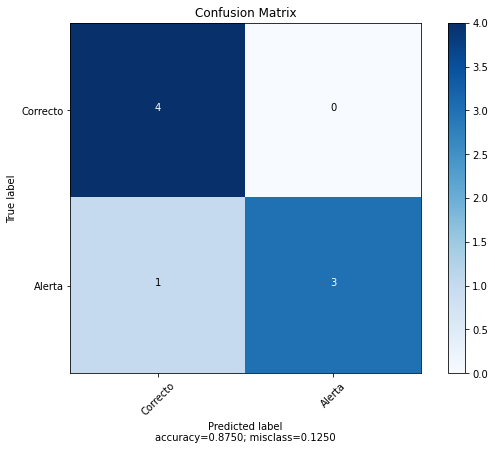

In [38]:
plot_confusion_matrix(cm = cmat, 
normalize = False,
target_names = list(dic.values()),
title = "Confusion Matrix")